# 计划是先使用Rigid进行粗对齐，然后使用3D slicer进行Model registration (in SlicerIGT extension)对齐

### 使用DAPI图像和CCF3的template图进行对齐即可，先用203m的样本尝试一下

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import tifffile

In [2]:
file = "/media/duan/DuanLab_Data/Yao2023/CCF2020/average_template_10.nii.gz"
average_template_image = sitk.ReadImage( file )
average_template_array = sitk.GetArrayViewFromImage( average_template_image )

file = "/media/duan/DuanLab_Data/Yao2023/CCF2020/annotation_10.nii.gz"
annotation_image = sitk.ReadImage( file )
annotation_array = sitk.GetArrayViewFromImage( annotation_image )

file = "/media/duan/DuanLab_Data/Yao2023/CCF2020/annotation_boundary_10.nii.gz"
annotation_boundary_image = sitk.ReadImage( file )
annotation_boundary_array = sitk.GetArrayViewFromImage( annotation_boundary_image )

In [3]:
# Function to print out image information
def image_info( img ) :
    print('size: ' + str(img.GetSize()) + ' voxels')
    print('spacing: ' + str(img.GetSpacing()) + ' mm' )
    print('direction: ' + str(img.GetDirection()) )
    print('origin: ' + str(img.GetOrigin()))

In [4]:
image_info(average_template_image)

size: (1320, 800, 1140) voxels
spacing: (0.009999999776482582, 0.009999999776482582, 0.009999999776482582) mm
direction: (-0.0, 0.0, -1.0, 1.0, -0.0, 0.0, 0.0, -1.0, 0.0)
origin: (5.695000171661377, -5.349999904632568, 5.21999979019165)


In [5]:
def plot_section( slice, cmap=plt.cm.Greys_r, fig_width = 6, fig_height = 6 ) :
    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)
    if cmap is not None :
        plt.imshow(slice, cmap=cmap)
    else :
        plt.imshow(slice)
    plt.axis("off")
    return fig, ax

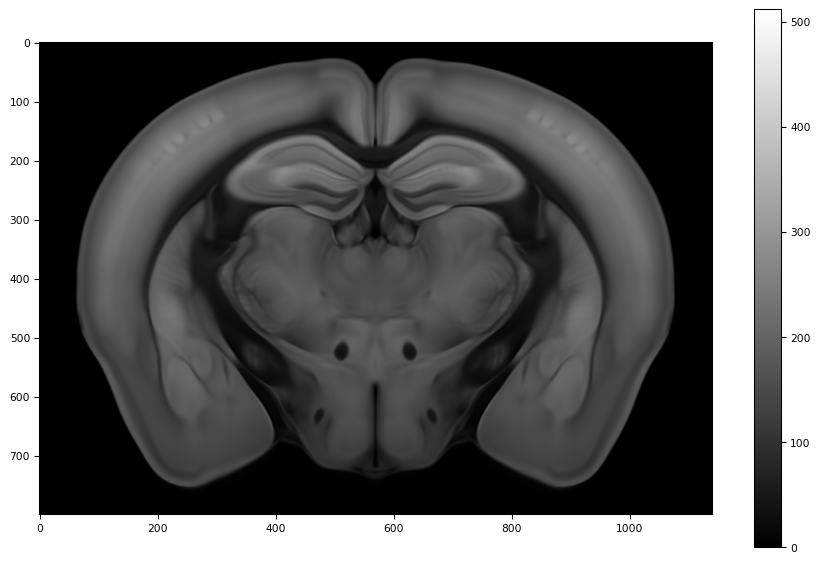

In [6]:
zindex =680
zslice = np.transpose(average_template_array[:,:,zindex])
tifffile.imshow(zslice, cmap = 'grey')
tifffile.imwrite("Registration_A4/average_template_680.tif", zslice)

In [7]:
zslice.shape[0]

800

## 在napari中先进行affine对齐

In [8]:
img = tifffile.imread("/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A4/morphology_AF405.tif")
img.shape

(18627, 16769)

In [9]:
round(zslice.shape[0]/img.shape[0], 3)

0.043

In [10]:
import cv2

In [11]:
scale_percent = round(zslice.shape[0]/img.shape[0], 3)  # 缩小到50%
new_width = int(img.shape[1] * scale_percent)
new_height = int(img.shape[0] * scale_percent)
resized_img = cv2.resize(img, (new_width, new_height))

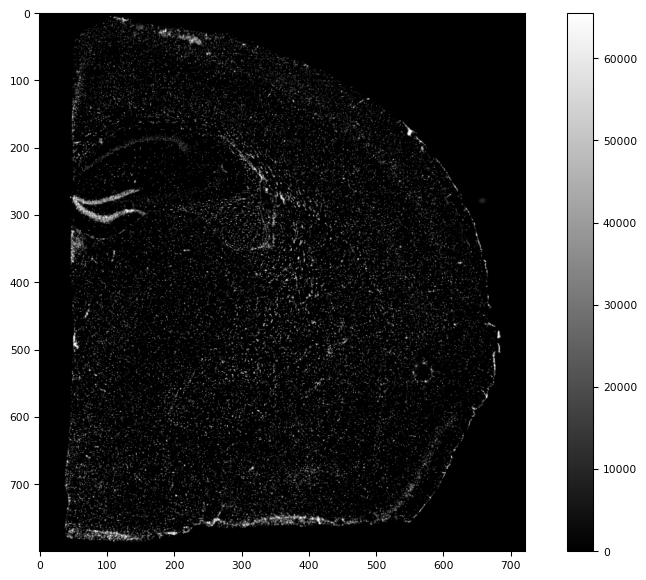

In [13]:
tifffile.imshow(resized_img, cmap = 'grey')
tifffile.imwrite("Registration_A4/9AA_A4_resize_DAPI.tif", resized_img)

In [ ]:
{"affine": [[0.8792573696076298, 0.0, 6.639830424967613], [0.0, 0.7842779962540953, 541.897272017512], [0.0, 0.0, 1.0]]}

In [12]:
affine_matrix = [[0.8792573696076298, 0.0, 6.639830424967613], [0.0, 0.7842779962540953, 541.897272017512], [0.0, 0.0, 1.0]]

In [13]:
import numpy as np

def adjust_affine_for_napari(affine_matrix):
    """
    将OpenCV坐标系的仿射矩阵调整为Napari坐标系
    """
    affine = np.array(affine_matrix)
    
    # 创建坐标交换矩阵
    # 从 (x,y) 转换为 (y,x)
    swap_matrix = np.array([
        [0, 1, 0],
        [1, 0, 0], 
        [0, 0, 1]
    ])
    
    # 调整仿射矩阵: swap * affine * swap^-1
    swap_inv = np.linalg.inv(swap_matrix)
    adjusted_affine = swap_matrix @ affine @ swap_inv
    
    return adjusted_affine

In [14]:
import cv2
import numpy as np

def apply_affine_transform(image, affine_matrix, wh):
    """
    应用仿射变换到图像上
    
    参数:
    image: 输入的numpy图像数组
    affine_matrix: 3x3仿射变换矩阵
    
    返回:
    变换后的图像
    """
    # 提取前两行作为2x3的仿射变换矩阵（OpenCV所需格式）
    affine_2x3 = np.array(affine_matrix)[:2, :]
    
    # 获取图像尺寸
    height, width = image.shape[:2]
    
    # 应用仿射变换
    transformed_image = cv2.warpAffine(
        image, 
        affine_2x3, 
        wh,
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0  # 黑色填充，可以修改为其他颜色
    )
    
    return transformed_image

In [15]:
transformed_img = apply_affine_transform(resized_img, adjust_affine_for_napari(affine_matrix), wh = zslice.shape[::-1])

In [16]:
transformed_img.shape

(800, 1140)

In [19]:
tifffile.imwrite("Registration_A4/9AA_A4_resize_DAPI_affine.tif", transformed_img)

#### 下面这个是用Slicer3D的方法是可行的，但也许不是目前最优，可能会被ask，目前最好还是使用STalign完成最后的细对齐

In [17]:
import numpy as np
import re

class SlicerTPSWarper:
    def __init__(self, transform_file=None, src_pts=None, dst_pts=None):
        """
        Mimics 3D Slicer's Thin Plate Spline transform behavior (2D, z=0).
        Input options:
          - transform_file: path to ITK .txt transform file (like yours)
          - src_pts, dst_pts: (N,2) arrays of corresponding landmarks
        """
        if transform_file:
            src_pts, dst_pts = self._load_from_file(transform_file)
        elif src_pts is None or dst_pts is None:
            raise ValueError("Either transform_file or (src_pts, dst_pts) must be provided.")
        
        src_pts = np.asarray(src_pts)
        dst_pts = np.asarray(dst_pts)
        assert src_pts.shape == dst_pts.shape and src_pts.shape[1] == 2, "Points must be (N,2)"
        
        self.src = src_pts
        self.dst = dst_pts
        self.N = len(src_pts)
        
        # Compute forward TPS (src → dst)
        self.coeffs_fwd, self.affine_fwd = self._compute_tps(self.src, self.dst)
        # Compute inverse TPS (dst → src) — crucial for Slicer-style application!
        self.coeffs_inv, self.affine_inv = self._compute_tps(self.dst, self.src)

    @staticmethod
    def _compute_tps(src, dst):
        """Compute TPS coefficients: radial + affine part."""
        N = src.shape[0]
        # Radial basis matrix K: U(r) = r^2 log(r)
        diff = src[:, None, :] - src[None, :, :]  # (N,N,2)
        r = np.linalg.norm(diff, axis=2)
        K = np.where(r == 0, 0.0, r**2 * np.log(r + 1e-12))

        # Setup linear system L * X = Y
        P = np.hstack([np.ones((N, 1)), src])  # (N,3)
        L = np.zeros((N + 3, N + 3))
        L[:N, :N] = K
        L[:N, N:] = P
        L[N:, :N] = P.T

        Y = np.zeros((N + 3, 2))
        Y[:N] = dst

        # Solve — use lstsq for robustness
        X, *_ = np.linalg.lstsq(L, Y, rcond=None)
        return X[:N], X[N:]  # coeffs (N,2), affine (3,2)

    @staticmethod
    def _warp(xy, control_pts, coeffs, affine):
        """
        Warp points using TPS.
        xy: (M,2) query points
        control_pts: (N,2) control points used in coefficient computation
        coeffs: (N,2)
        affine: (3,2)
        """
        M = xy.shape[0]
        # Affine part
        aff = np.hstack([np.ones((M, 1)), xy]) @ affine  # (M,2)
        # Radial part
        diff = xy[:, None, :] - control_pts[None, :, :]  # (M,N,2)
        r = np.linalg.norm(diff, axis=2)
        U = np.where(r == 0, 0.0, r**2 * np.log(r + 1e-12))  # (M,N)
        rad = U @ coeffs  # (M,2)
        return aff + rad

    def forward(self, pts):
        """Warp from source space → target space (like Slicer's 'transform applied to points')"""
        pts = np.asarray(pts)
        if pts.ndim == 1:
            pts = pts[None, :]
        return self._warp(pts, self.src, self.coeffs_fwd, self.affine_fwd)

    def inverse(self, pts):
        """Warp from target space → source space (like Slicer's 'inverse transform')"""
        pts = np.asarray(pts)
        if pts.ndim == 1:
            pts = pts[None, :]
        return self._warp(pts, self.dst, self.coeffs_inv, self.affine_inv)

    def _load_from_file(self, filepath):
        """Parse ITK .txt transform file like yours."""
        with open(filepath, 'r') as f:
            content = f.read()

        # Extract Parameters and FixedParameters using regex
        params_match = re.search(r'Parameters:\s*([-\d.\s]+)', content)
        fixed_match = re.search(r'FixedParameters:\s*([-\d.\s]+)', content)

        if not params_match or not fixed_match:
            raise ValueError("Could not parse Parameters or FixedParameters from file.")

        def parse_points(s):
            vals = np.array([float(x) for x in s.split()])
            pts = vals.reshape(-1, 3)[:, :2]  # drop z (all 0)
            return pts

        dst_pts = parse_points(params_match.group(1))  # Parameters = target points
        src_pts = parse_points(fixed_match.group(1))  # FixedParameters = source points
        return src_pts, dst_pts

    def verify(self, tol=1e-6):
        """Check that forward(src) ≈ dst and inverse(dst) ≈ src."""
        fwd_err = np.max(np.abs(self.forward(self.src) - self.dst))
        inv_err = np.max(np.abs(self.inverse(self.dst) - self.src))
        print(f"Forward warp error (src→dst): {fwd_err:.2e}")
        print(f"Inverse warp error (dst→src): {inv_err:.2e}")
        assert fwd_err < tol and inv_err < tol, "TPS verification failed!"
        print("✅ TPS transform verified.")

# ------------------------
# ✅ USAGE EXAMPLE
# ------------------------

# # 1. Load from your .txt file (replace path)
# warper = SlicerTPSWarper(transform_file='/media/duan/DuanLab_Data/ZC_epi/Code/P16_OpenFISH/registration/OpenFISHtoCCF2020.txt')

# # 2. Verify correctness (should be ~1e-12)
# warper.verify()

# # 3. Apply to NEW 2D point set (e.g., cell coordinates, ROI centers)
# new_points = np.array([
#     [600, 250],
#     [800, 300],
#     [900, 700],
#     [700, 500]
# ])

# # Forward: map from *your original space* → *CCF/registered space*
# warped_points = warper.forward(new_points)
# print("Original points → Registered (CCF) space:")
# for p, wp in zip(new_points, warped_points):
#     print(f"  ({p[0]:.1f}, {p[1]:.1f}) → ({wp[0]:.1f}, {wp[1]:.1f})")

# # Inverse: map from CCF space → your original space
# back_points = warper.inverse(warped_points)
# print("\nRound-trip error (should be ~0):")
# print(np.max(np.abs(back_points - new_points)))

#### STalign

### 首先把前面的变换应用到坐标点上

In [18]:
import scanpy as sc

adata = sc.read_h5ad("All_Aligned/9AA_A4_transferFISH.h5ad")
adata

AnnData object with n_obs × n_vars = 16169 × 99
    obs: 'region', 'Name', 'x', 'y', 'area', 'leiden', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_FP', 'log1p_total_counts_FP', 'pct_counts_FP', 'log1p_area', 'Sample', 'cell_type', 'Batch'
    uns: 'Batch_colors', 'Sample_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'counts_corrected'
    obsp: 'connectivities', 'distances'

In [23]:
adata.obsm['spatial'] = adata.obs[['x','y']].to_numpy()

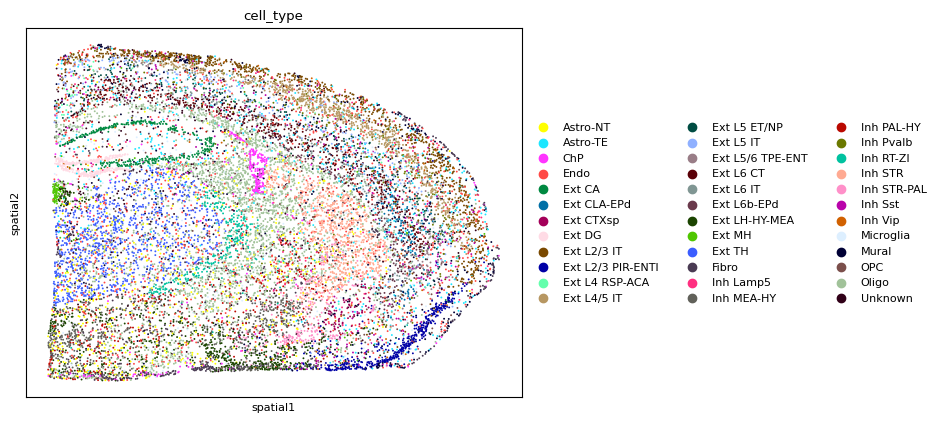

In [20]:
sc.pl.embedding(adata, basis = 'spatial', color = 'cell_type')

#### 先应用缩放

In [21]:
scale_percent

0.043

In [121]:
adata.obs['x'] = adata.obsm['spatial'][:,0]
adata.obs['y'] = adata.obsm['spatial'][:,1]

In [22]:
adata.obs['x_scaled'] = adata.obs['x'] * scale_percent
adata.obs['y_scaled'] = adata.obs['y'] * scale_percent

#### 再应用affine

In [23]:
H = adjust_affine_for_napari(affine_matrix)

In [24]:
H

array([[  0.784278  ,   0.        , 541.89727202],
       [  0.        ,   0.87925737,   6.63983042],
       [  0.        ,   0.        ,   1.        ]])

In [25]:
x_img = adata.obs['x_scaled'].values
y_img = adata.obs['y_scaled'].values

In [26]:
points_h = np.stack([x_img, y_img, np.ones_like(x_img)], axis=1)  # shape (N, 3)

transformed_h = (H @ points_h.T).T  # shape (N, 3)

# 5. 转回非齐次坐标
x_img_aligned = transformed_h[:, 0] / transformed_h[:, 2]
y_img_aligned = transformed_h[:, 1] / transformed_h[:, 2]

# 6. 保存结果
adata.obs.loc[:, 'x_affine'] = x_img_aligned
adata.obs.loc[:, 'y_affine'] = y_img_aligned

In [27]:
adata.obsm['spatial_affine'] = adata.obs[['x_affine', 'y_affine']].to_numpy()

In [28]:
new_points = adata.obsm['spatial_affine']

In [29]:
warper = SlicerTPSWarper(transform_file='/media/duan/sda2/MALDI/Data/20251014_5FAD/Registration_A4/Transform.txt')

# 2. Verify correctness (should be ~1e-12)
warper.verify()

Forward warp error (src→dst): 3.18e-12
Inverse warp error (dst→src): 1.23e-11
✅ TPS transform verified.


In [30]:
warped_points = warper.forward(new_points)

In [31]:
adata.obsm['spatial_warping'] = warped_points

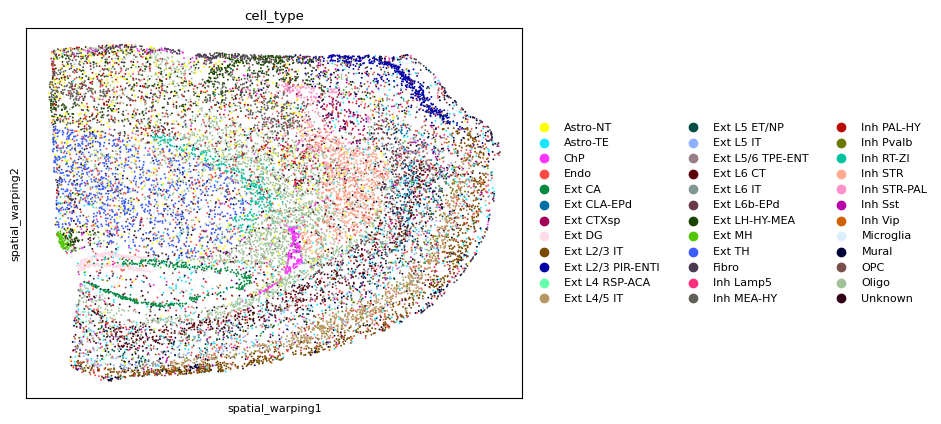

In [32]:
sc.pl.embedding(adata, basis = 'spatial_warping', color = 'cell_type')

## plot成DAPI检查一下

In [65]:
A = tifffile.imread("Registration_A4/average_template_680.tif")
A.shape

(800, 1140)

In [66]:
W = np.zeros(shape = A.shape)
g_counts = adata.obs['nCount_RNA'].to_numpy()
g_counts = STalign.normalize(g_counts, t_min=0, t_max=255)

for i, (x,y) in enumerate(adata.obsm['spatial_warping']):
    r = 1
    col = np.round(x).astype(int)
    row = np.round(y).astype(int)
    
    row0 = np.floor(row-r).astype(int)
    row1 = np.ceil(row+r).astype(int)                    
    col0 = np.floor(col-r).astype(int)
    col1 = np.ceil(col+r).astype(int)
    # we need boundary conditions
    row0 = np.minimum(np.maximum(row0,0),W.shape[0]-1)
    row1 = np.minimum(np.maximum(row1,0),W.shape[0]-1)
    col0 = np.minimum(np.maximum(col0,0),W.shape[1]-1)
    col1 = np.minimum(np.maximum(col1,0),W.shape[1]-1)

    W[row0:row1, col0:col1] += g_counts[i]

In [67]:
tifffile.imwrite("Registration_A4/9AA_A4_resize_DAPI_affine_warping.tif", W.astype(np.uint8))

In [335]:
adata.write_h5ad("")

AnnData object with n_obs × n_vars = 46408 × 106
    obs: 'umi_sct', 'log_umi_sct', 'gene_sct', 'log_gene_sct', 'umi_per_gene_sct', 'log_umi_per_gene_sct', 'leiden', 'nico_ct', 'x', 'y', 'x_scaled', 'y_scaled', 'x_affine', 'y_affine'
    var: 'Intercept_sct', 'log_umi_sct', 'theta_sct', 'Intercept_step1_sct', 'log_umi_step1_sct', 'dispersion_step1_sct', 'genes_step1_sct', 'log10_gmean_sct'
    uns: 'leiden', 'neighbors', 'pca', 'umap', 'nico_ct_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_affine', 'spatial_warping'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

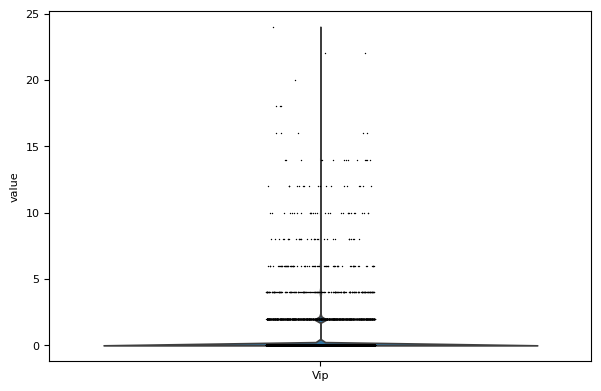

In [339]:
sc.pl.violin(adata, keys = 'Vip')

### 接下来试试可不可以把parcellation弄到数据上

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x757da00ae710>)

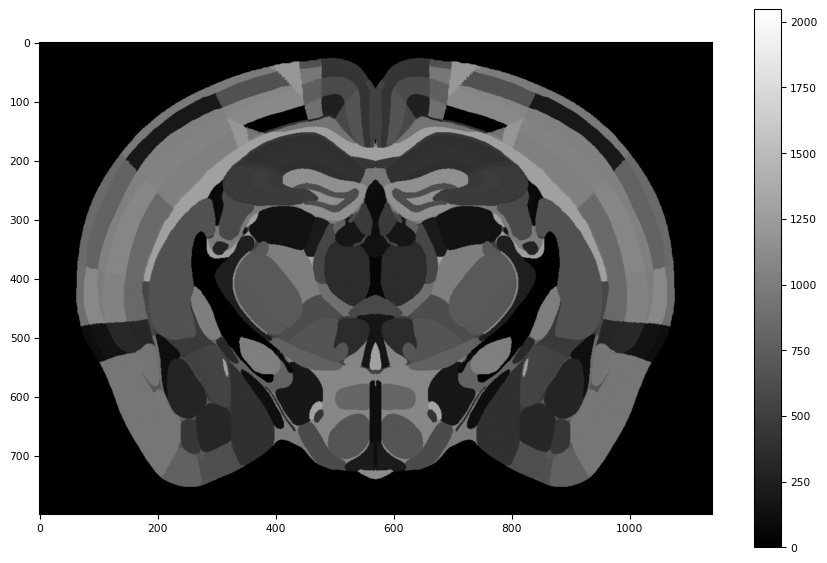

In [33]:
zindex =680
zslice = np.transpose(annotation_array[:,:,zindex])
tifffile.imshow(zslice, cmap = 'grey')
#tifffile.imwrite("registration/average_template_700.tif", zslice)

In [34]:
pivot = pd.read_csv("/media/duan/DuanLab_Data/Yao2023/CCF2020/parcellation_to_parcellation_term_membership_acronym.csv", index_col=0)
name = pd.read_csv("/media/duan/DuanLab_Data/Yao2023/CCF2020/parcellation_to_parcellation_term_membership_name.csv", index_col = 0)
color = pd.read_csv("/media/duan/DuanLab_Data/Yao2023/CCF2020/parcellation_to_parcellation_term_membership_color.csv", index_col = 0)
pivot

organ      category    division   structure  \
parcellation_index                                                     
0                   unassigned    unassigned  unassigned  unassigned   
1                        brain          grey          HY         TMv   
2                        brain          grey   Isocortex       SSp-m   
5                        brain  fiber tracts        lfbs         cst   
6                        brain          grey           P         PSV   
...                        ...           ...         ...         ...   
1323                     brain          grey          MB         IPN   
1324                     brain          grey          MB         IPN   
1325                     brain          grey          MB         IPN   
1326                     brain          grey          MB         IPN   
1327                     brain          grey          MB         PAG   

                   substructure  
parcellation_index               
0                    unassigned  
1                           TMv  
2                       SSp-m6b  
5                           int  
6                           PSV  
...                         ...  
1323                        IPI  
1324                       IPDM  
1325                       IPDL  
1326                       IPRL  
1327                        Su3  

[688 rows x 5 columns]

In [35]:
color

organ_color category_color division_color structure_color  \
parcellation_index                                                             
0                      #000000        #000000        #000000         #000000   
1                      #FFFFFF        #BFDAE3        #E64438         #FF4C3E   
2                      #FFFFFF        #BFDAE3        #70FF71         #188064   
5                      #FFFFFF        #CCCCCC        #CCCCCC         #CCCCCC   
6                      #FFFFFF        #BFDAE3        #FF9B88         #FFAE6F   
...                        ...            ...            ...             ...   
1323                   #FFFFFF        #BFDAE3        #FF64FF         #FFA6FF   
1324                   #FFFFFF        #BFDAE3        #FF64FF         #FFA6FF   
1325                   #FFFFFF        #BFDAE3        #FF64FF         #FFA6FF   
1326                   #FFFFFF        #BFDAE3        #FF64FF         #FFA6FF   
1327                   #FFFFFF        #BFDAE3        #FF64FF         #FF90FF   

                   substructure_color  
parcellation_index                     
0                             #000000  
1                             #FF4C3E  
2                             #188064  
5                             #CCCCCC  
6                             #FFAE6F  
...                               ...  
1323                          #FFA6FF  
1324                          #FFA6FF  
1325                          #FFA6FF  
1326                          #FFA6FF  
1327                          #FF90FF  

[688 rows x 5 columns]

In [36]:
import scanpy as sc

In [37]:
adata.obsm['spatial_warping']

array([[634.87049191,  23.26119538],
       [637.2960052 ,  23.0699085 ],
       [635.93505655,  24.68562321],
       ...,
       [647.20530488, 702.52408556],
       [649.47536689, 702.89120716],
       [639.43877808, 702.23754876]])

In [38]:
pdex = [zslice[round(y),round(x)] for x,y in adata.obsm['spatial_warping']]

In [39]:
adata.obs['category'] = pivot.loc[pdex, 'category'].values
adata.obs['division'] = pivot.loc[pdex, 'division'].values
adata.obs['structure'] = pivot.loc[pdex, 'structure'].values
adata.obs['substructure'] = pivot.loc[pdex, 'substructure'].values

In [40]:
adata.obs['substructure']

1        unassigned
2        unassigned
3        unassigned
4        unassigned
7        unassigned
            ...    
45497            TU
45499           VMH
45501            TU
45502            TU
45504            TU
Name: substructure, Length: 16169, dtype: object

In [41]:
color.loc[pdex, 'substructure_color'].values

array(['#000000', '#000000', '#000000', ..., '#F2483B', '#F2483B',
       '#F2483B'], dtype=object)

In [42]:
color_dict = {}
for k,v in zip(pivot.loc[pdex, 'structure'].values, color.loc[pdex, 'structure_color'].values):
    color_dict[k] = v

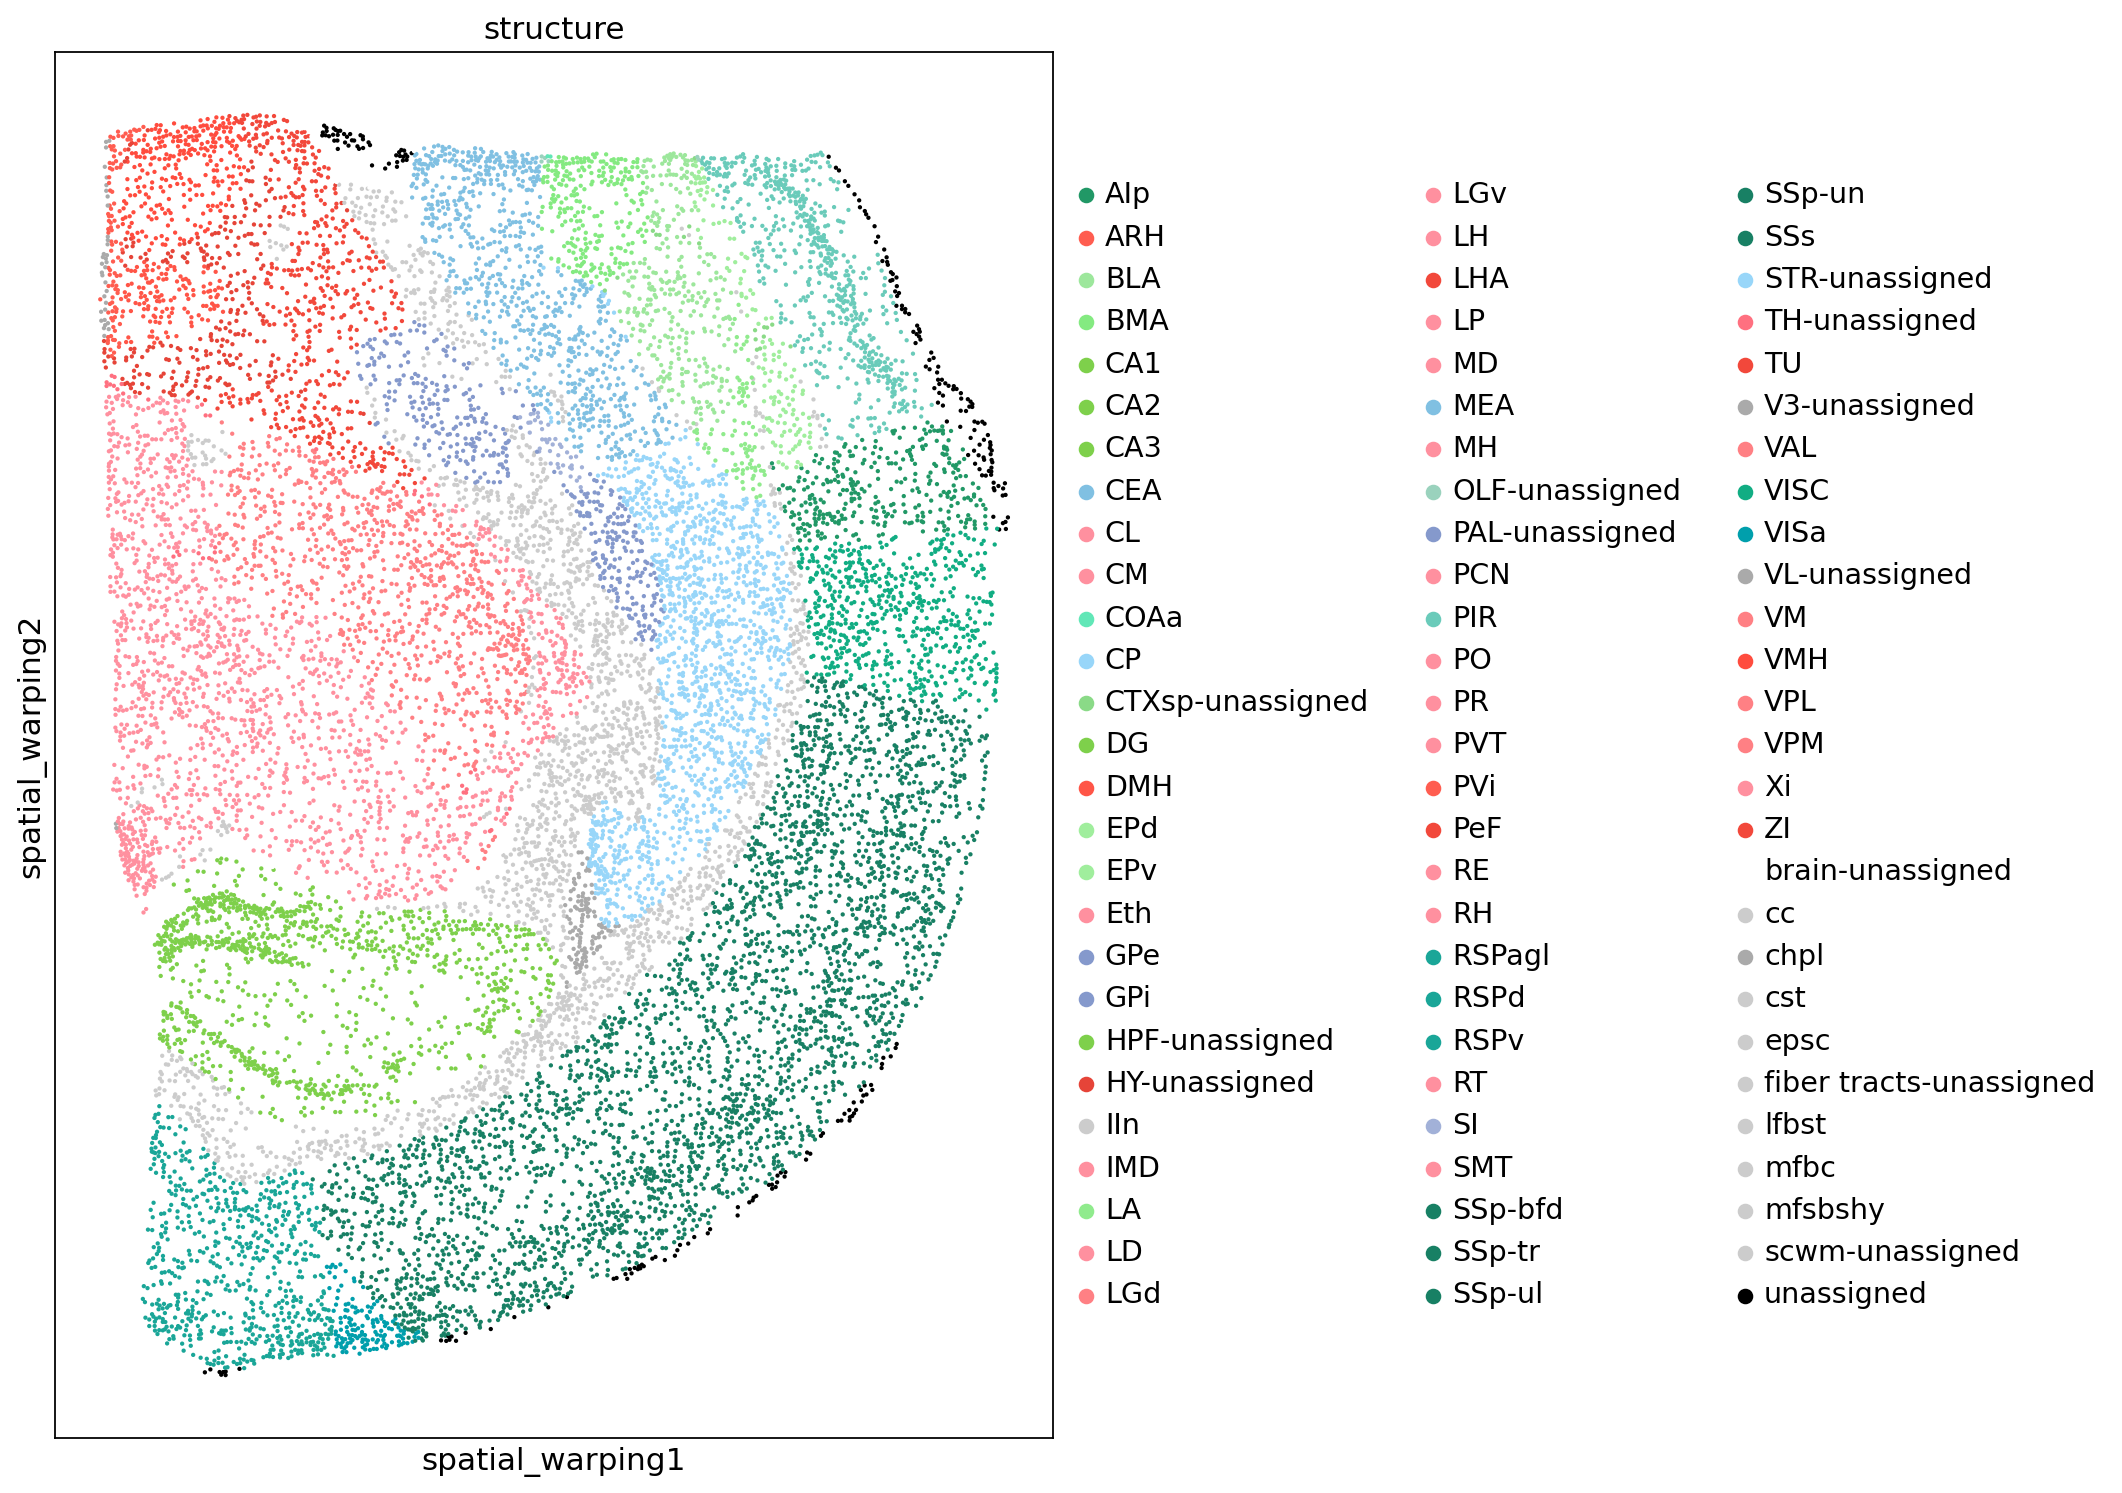

In [43]:
sc.set_figure_params(figsize = (8, 11.4))
sc.pl.embedding(adata, basis = 'spatial_warping', color = 'structure', palette=color_dict, size = 15)

In [44]:
adata.write_h5ad("All_Aligned/9AA_A4_transferFISH_toCCF.h5ad")

In [90]:
adata.obsm[1, :]

TypeError: unhashable type: 'slice'

In [91]:
adata.obsm['spatial_warping'][:, 1] = 0 - adata.obsm['spatial_warping'][:, 1]

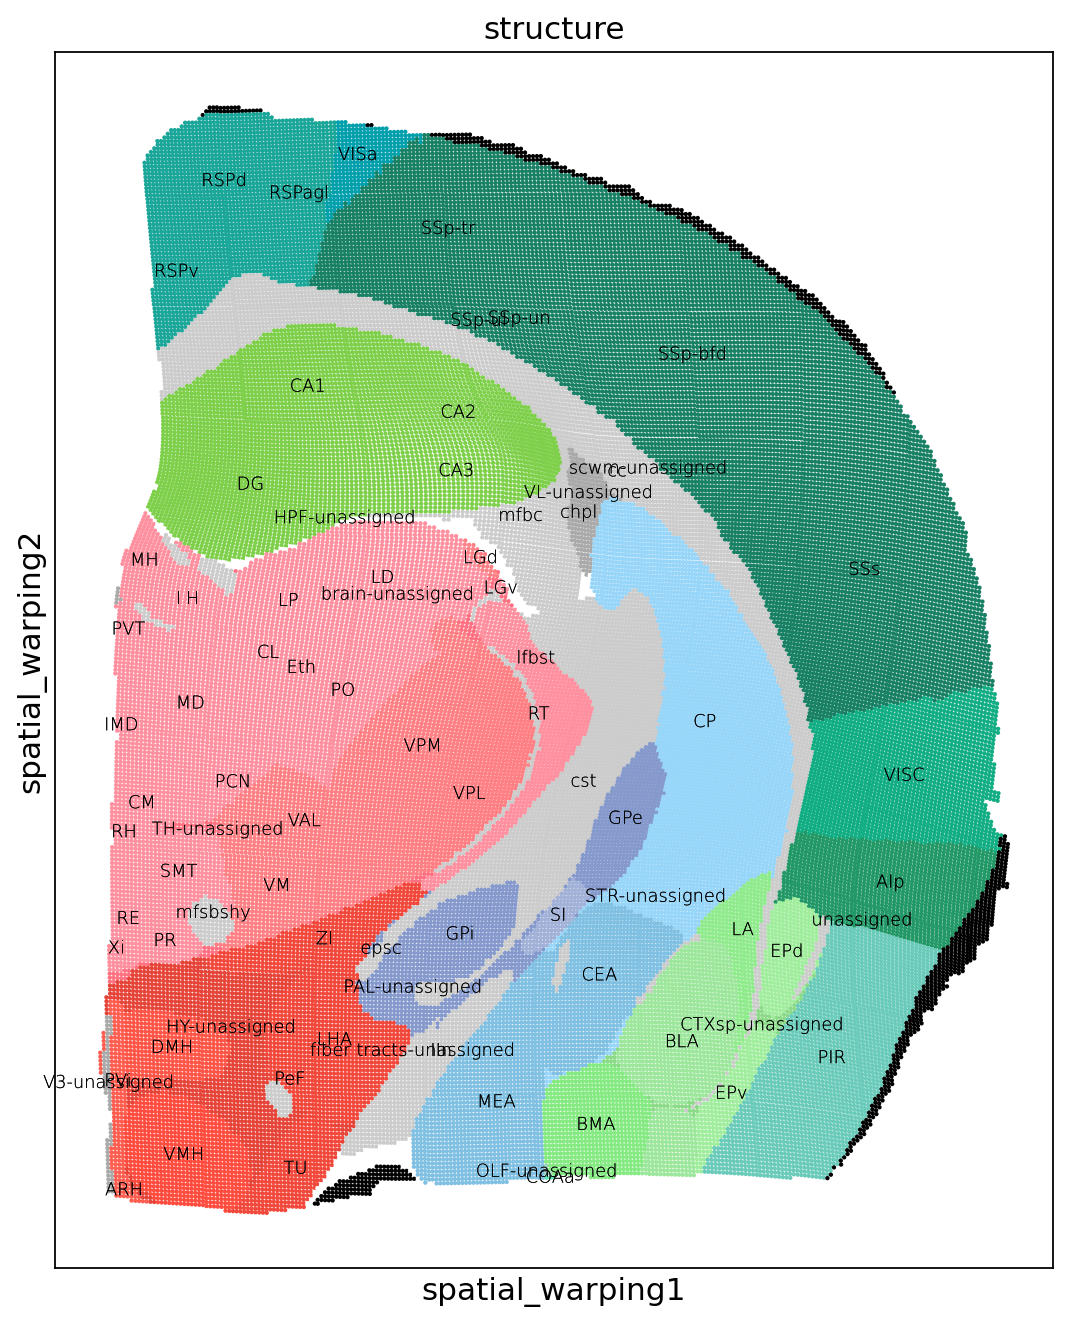

In [97]:
sc.set_figure_params(figsize = (8, 10))
sc.pl.embedding(adata, basis = 'spatial_warping', color = 'structure', palette=color_dict, size = 15, legend_loc='on data', legend_fontsize=8, legend_fontweight=2, legend_fontoutline=0, save = '9AA_A4_toCCF.pdf')

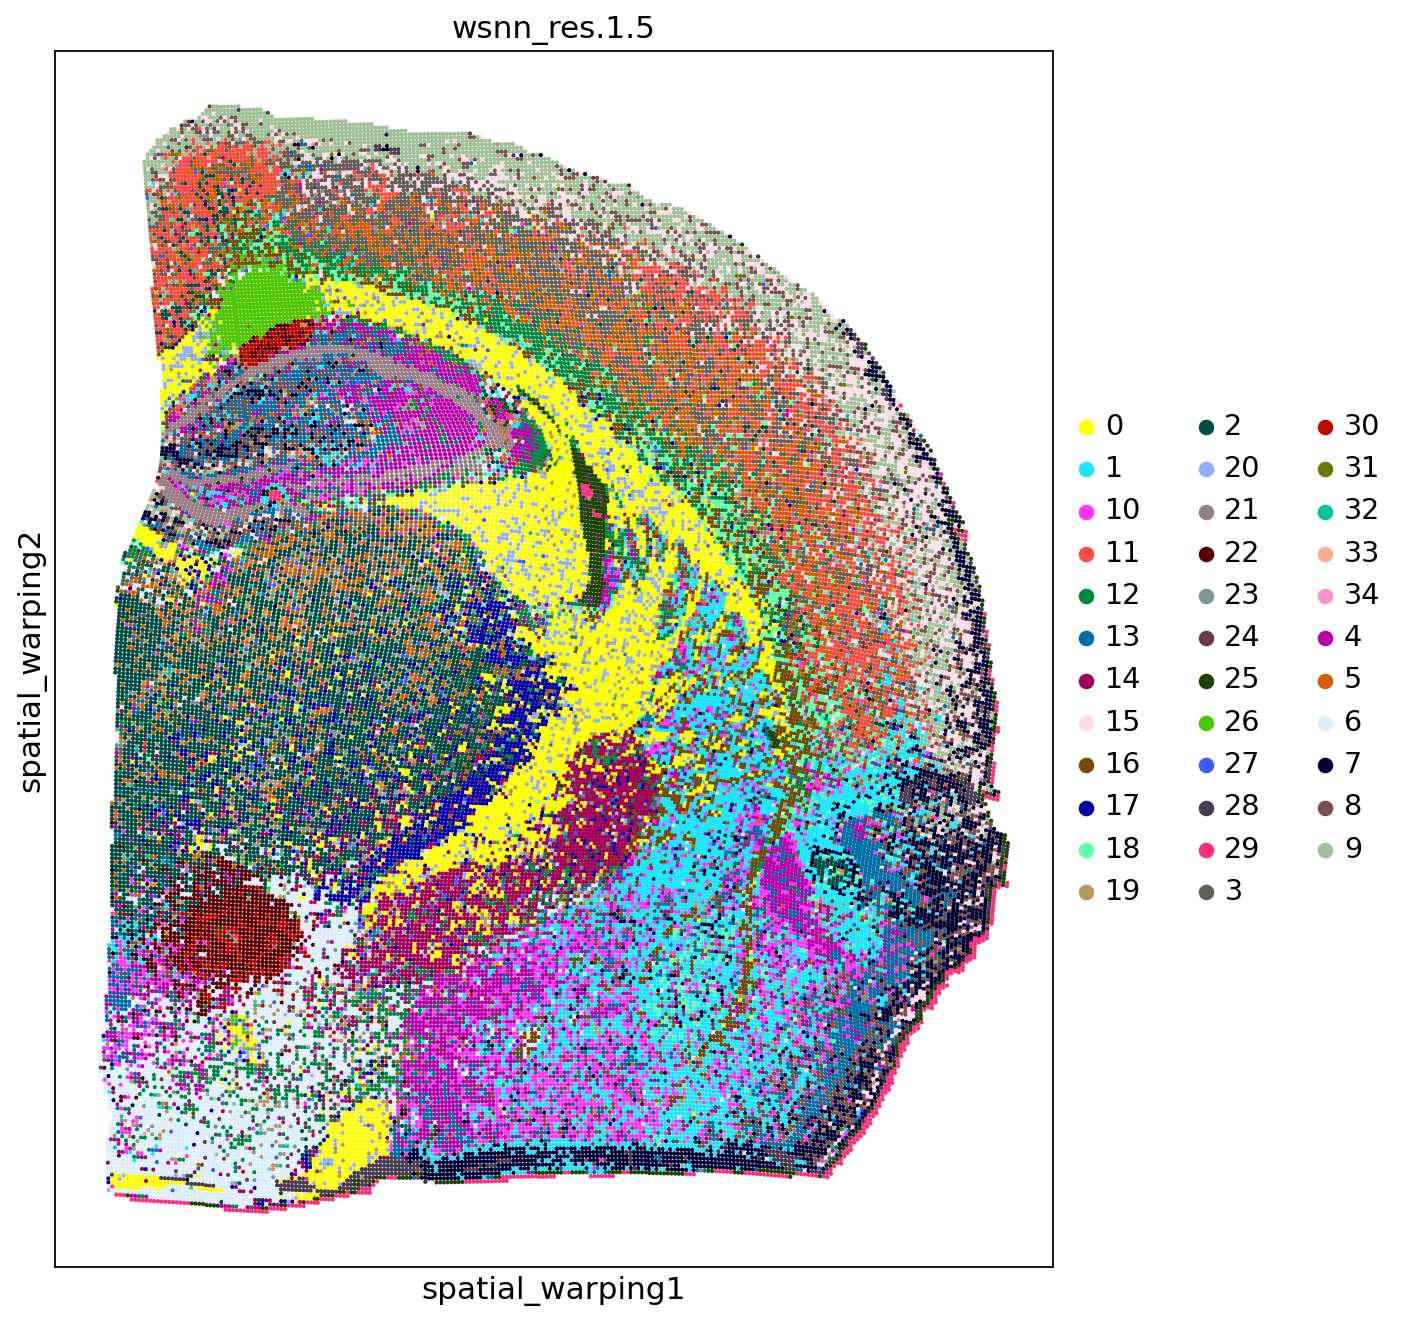

In [101]:
sc.set_figure_params(figsize = (8, 10))
sc.pl.embedding(adata, basis = 'spatial_warping', color = 'wsnn_res.1.5', size = 15, save = '9AA_A4_WNN.pdf')